In [1]:
import os
import sys
import pandas as pd
from tqdm import tqdm
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join
from datetime import datetime

In [2]:
# Import custom modules
project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_path = os.path.join(project_path, "src")

sys.path.append(src_path)

In [3]:
from preprocessing import Create_non_overlapping_eegID_data
from dataloader import DataGenerator, load_train_spectrograms, load_eeg_spectrograms
from visualization import plot_batch
from scheduler import cosine_scheduler, step_scheduler
from buildmodel import build_model
from train_model import train_model
from kaggle_kl_div import score

In [4]:
print(f"TensorFlow version = {tf.__version__}")

# GPU Configuration
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) <= 1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f"Using {len(gpus)} GPU")
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Using {len(gpus)} GPUs")

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

# Enable mixed precision
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print("Mixed precision enabled")

TensorFlow version = 2.16.1
Using 0 GPU
Mixed precision enabled


In [5]:
# Data configuration
DATA_PATH = "../data/raw/hms-harmful-brain-activity-classification"
df = pd.read_csv(join(DATA_PATH, "train.csv"))

TARGETS = df.columns[-6:]
READ_SPEC_FILES = False
READ_EEG_SPEC_FILES = False
PATH_TO_SPECTROGRAMS = join(DATA_PATH, "train_spectrograms")
TARS = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
TARS2 = {value: key for key, value in TARS.items()}

print("Train shape:", df.shape)
print("Targets:", list(TARGETS))

# Create non-overlapping eegID data
train, y_data = Create_non_overlapping_eegID_data(df, TARGETS)

# Load data
spectrograms = load_train_spectrograms(PATH_TO_SPECTROGRAMS, READ_SPEC_FILES)
all_eegs = load_eeg_spectrograms(train, READ_EEG_SPEC_FILES)

Train shape: (106800, 15)
Targets: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
Train non-overlapp eeg_id shape: (17089, 12)
There are 11138 spectrogram parquets


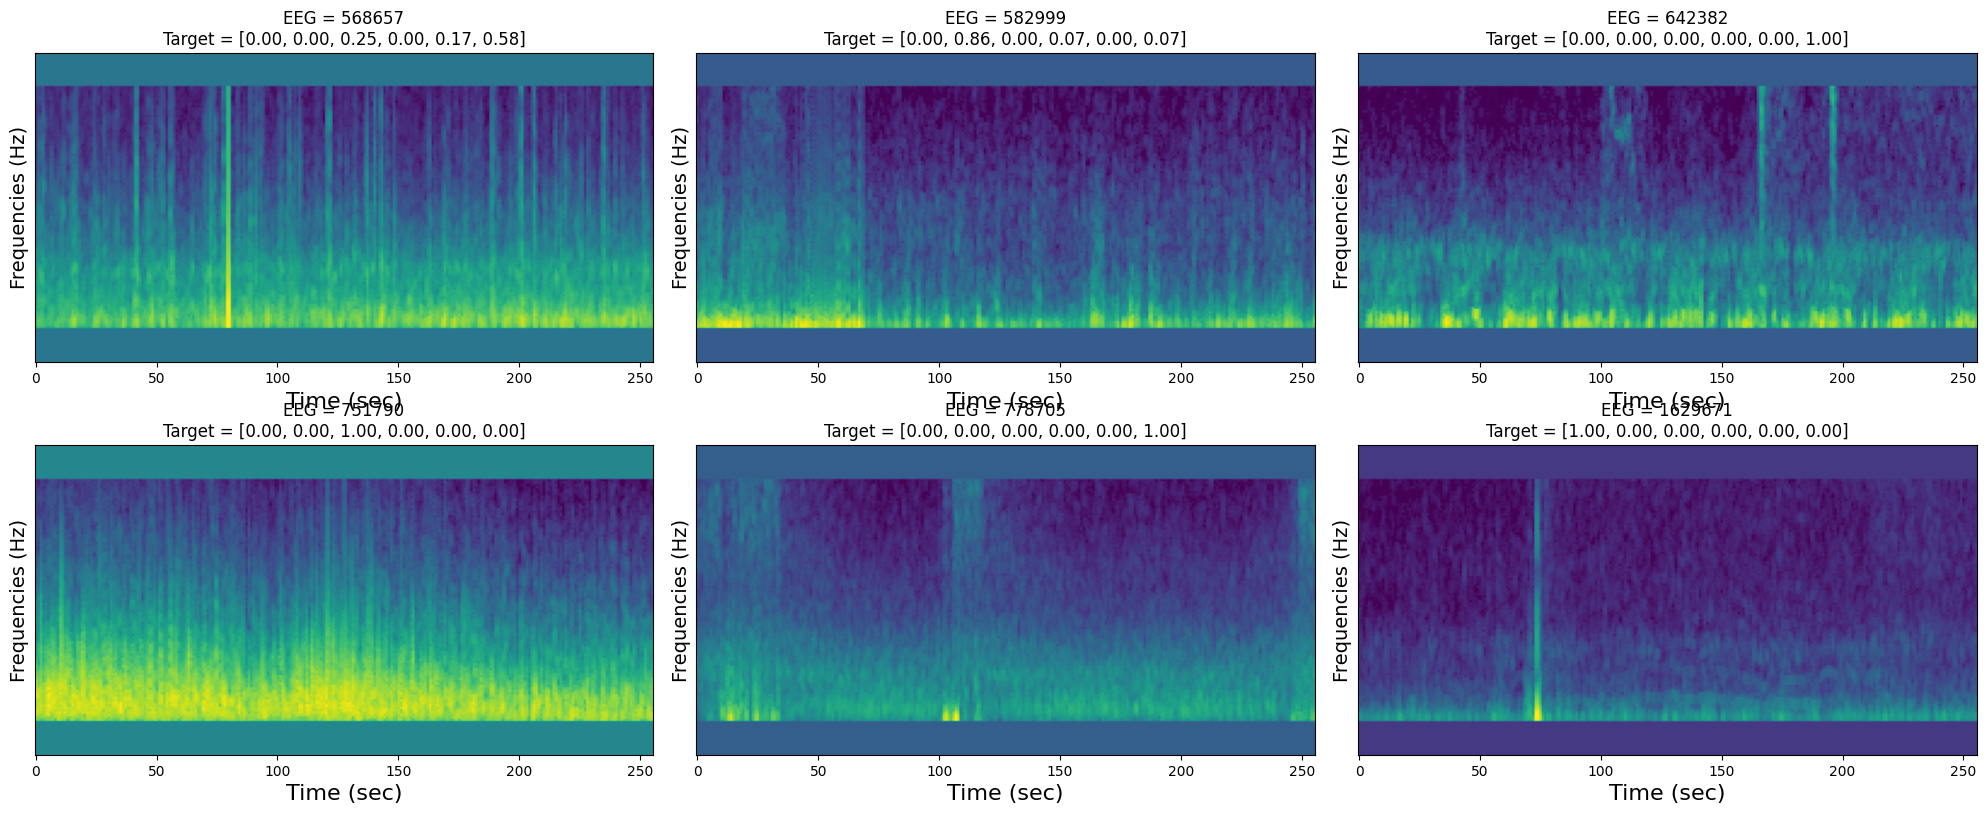

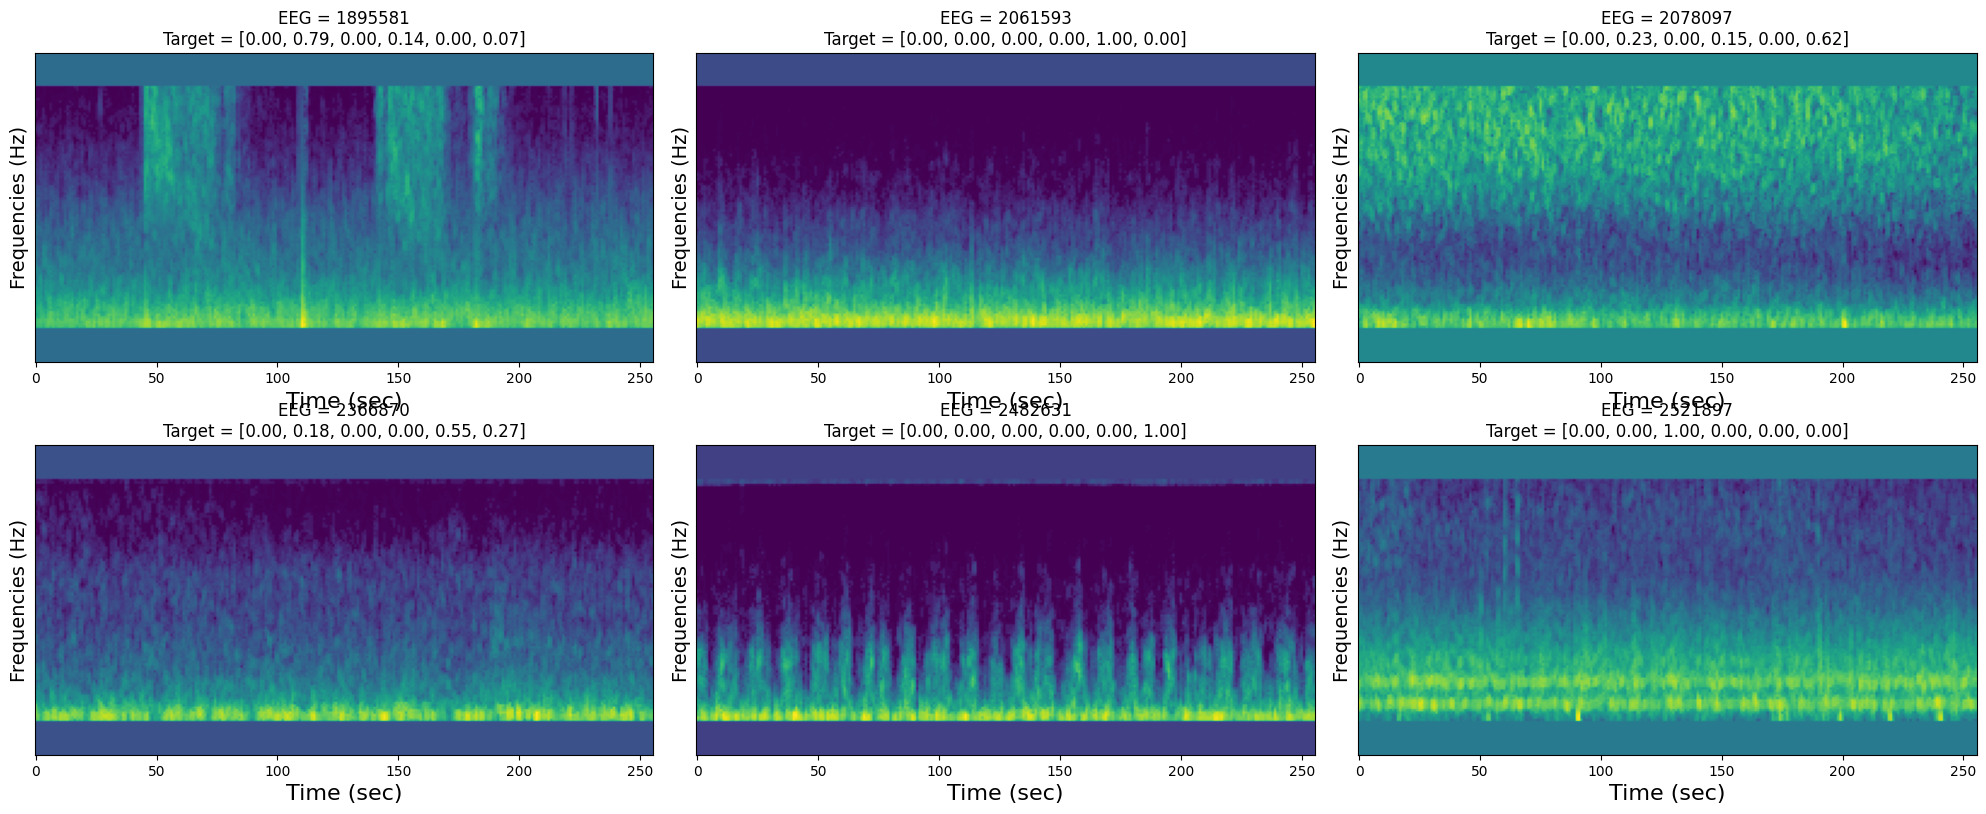

In [6]:
# Constants
ROWS = 2
COLS = 3
BATCHES = 2

# Initialize the DataGenerator
gen = DataGenerator(
    data=train,
    batch_size=32,
    shuffle=False,
    augment=False,
    mode="train",
    specs=spectrograms,
    eeg_specs=all_eegs,
    TARGETS=TARGETS,
)

# Iterate through the specified number of batches and plot them
for batch_index, (x_batch, y_batch) in enumerate(gen):
    plot_batch(x_batch, y_batch, ROWS, COLS, batch_index, train.eeg_id.values, TARGETS)
    if batch_index == BATCHES - 1:
        break

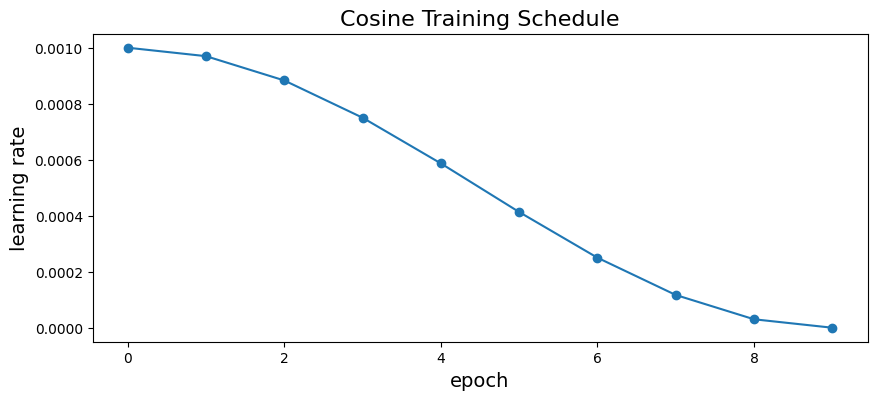

In [7]:
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 10

rng = [i for i in range(EPOCHS2)]
lr_y = [
    cosine_scheduler(
        x, LR_START, LR_MAX, LR_MIN, LR_RAMPUP_EPOCHS, LR_SUSTAIN_EPOCHS, EPOCHS2
    )
    for x in rng
]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, "-o")
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Cosine Training Schedule", size=16)
plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(cosine_scheduler, verbose=True)

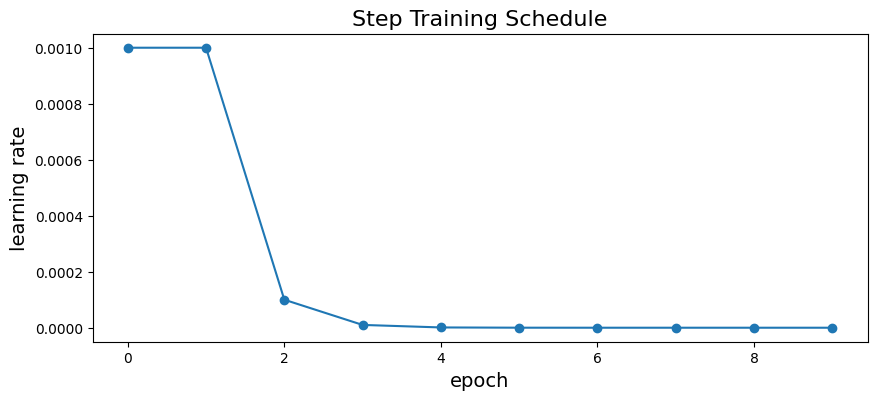

In [8]:
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 10

rng = [i for i in range(EPOCHS)]
y = [
    step_scheduler(
        x,
        LR_START=LR_START,
        LR_MAX=LR_MAX,
        LR_RAMPUP_EPOCHS=LR_RAMPUP_EPOCHS,
        LR_SUSTAIN_EPOCHS=LR_SUSTAIN_EPOCHS,
        LR_STEP_DECAY=LR_STEP_DECAY,
        EVERY=EVERY,
        EPOCHS=EPOCHS,
    )
    for x in rng
]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, "o-")
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(step_scheduler, verbose=True)

In [9]:
results = []

models_versions = ["b0", "b1", "b2", "b3", "b4", "b5"]
lr_schedulers = [LR, LR2]
scheduler_names = ["Cosine", "Step"]

# Use tqdm to wrap the outer loop for visual progress tracking
for version in tqdm(models_versions, desc="Model Versions"):
    for scheduler, name in zip(lr_schedulers, scheduler_names):
        start_time = time.time()  # Start time measurement

        all_oof, all_true = train_model(
            train=train,
            DataGenerator=DataGenerator,
            strategy=strategy,
            build_model_fn=build_model,
            EPOCHS=10,
            LR_scheduler=scheduler,  # Pass the correct scheduler
            TARGETS=TARGETS,
            USE_KAGGLE_SPECTROGRAMS=USE_KAGGLE_SPECTROGRAMS,
            USE_EEG_SPECTROGRAMS=USE_EEG_SPECTROGRAMS,
            specs=spectrograms,
            eeg_specs=all_eegs,
            version=version,
            LOAD_MODELS_FROM=None,
            K_FOLDS=3,
        )

        training_time = time.time() - start_time  # Calculate training time

        # Calculate CV score
        oof = pd.DataFrame(all_oof)
        oof["id"] = range(len(oof))

        true = pd.DataFrame(all_true)
        true["id"] = range(len(true))

        cv_score = score(solution=true, submission=oof, row_id_column_name="id")
        results.append(
            {
                "Model Version": version,
                "LR Schedule": name,
                "CV Score": cv_score,
                "Training Time (s)": training_time,  # Store training time in results
            }
        )

Model Versions:   0%|          | 0/6 [00:00<?, ?it/s]

### Fold 1/3 with 100% of data

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 1635s 4s/step - loss: 1.1406 - val_loss: 1.6213 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 1581s 4s/step - loss: 0.7831 - val_loss: 0.7837 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 1575s 4s/step - loss: 0.6331 - val_loss: 0.7237 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 1595s 4s/step - loss: 0.5289 - val_loss: 0.6905 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 1592s 4s/step - loss: 0.4415 - val_loss: 0.6765 - learning_rate: 8.6480e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 1595s 4s/s

c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 2353s 7s/step - loss: 1.1872 - val_loss: 1.6670 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 2285s 6s/step - loss: 0.7863 - val_loss: 0.8263 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 2293s 6s/step - loss: 0.6367 - val_loss: 0.7173 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 2287s 6s/step - loss: 0.5414 - val_loss: 0.6850 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 2295s 6s/step - loss: 0.4597 - val_loss: 0.6761 - learning_rate: 8.6480e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 2289s 6s/s

Model Versions:  17%|█▋        | 1/6 [39:06:56<195:34:41, 140816.21s/it]

### Fold 1/3 with 100% of data

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 4462s 12s/step - loss: 1.3080 - val_loss: 1.3407 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 4342s 12s/step - loss: 0.8998 - val_loss: 0.9126 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 4370s 12s/step - loss: 0.7596 - val_loss: 0.7472 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 4360s 12s/step - loss: 0.6512 - val_loss: 0.7111 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 4368s 12s/step - loss: 0.5694 - val_loss: 0.6727 - learning_rate: 8.6480e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 4353s

c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 6100s 17s/step - loss: 1.3316 - val_loss: 1.7359 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 5949s 17s/step - loss: 0.9280 - val_loss: 1.0312 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 5991s 17s/step - loss: 0.7835 - val_loss: 0.7712 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 5939s 17s/step - loss: 0.6801 - val_loss: 0.7010 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 5964s 17s/step - loss: 0.6085 - val_loss: 0.6865 - learning_rate: 8.6480e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 5938s

Model Versions:  33%|███▎      | 2/6 [133:37:32<286:48:07, 258121.89s/it]

### Fold 1/3 with 100% of data

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 6701s 19s/step - loss: 1.3074 - val_loss: 1.2973 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 6532s 18s/step - loss: 0.8868 - val_loss: 0.9037 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 6518s 18s/step - loss: 0.7467 - val_loss: 0.7409 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 6540s 18s/step - loss: 0.6230 - val_loss: 0.6768 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 6537s 18s/step - loss: 0.5513 - val_loss: 0.6603 - learning_rate: 8.6480e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 6532s

c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 8086s 23s/step - loss: 1.3550 - val_loss: 1.4968 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 8014s 22s/step - loss: 0.9419 - val_loss: 0.9090 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 7957s 22s/step - loss: 0.7885 - val_loss: 0.8527 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 7937s 22s/step - loss: 0.6855 - val_loss: 0.7267 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 7911s 22s/step - loss: 0.6005 - val_loss: 0.7007 - learning_rate: 8.6480e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 7929s

Model Versions:  50%|█████     | 3/6 [264:04:12<295:34:22, 354687.45s/it]

### Fold 1/3 with 100% of data

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


c:\Users\aliseydi\miniconda3\envs\hbaenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 9321s 26s/step - loss: 1.3359 - val_loss: 1.6289 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/10
 86/356 ━━━━━━━━━━━━━━━━━━━━ 1:44:52 23s/step - loss: 0.9824

Model Versions:  50%|█████     | 3/6 [267:13:32<267:13:32, 320670.68s/it]


KeyboardInterrupt: 

In [10]:
results

[{'Model Version': 'b0',
  'LR Schedule': 'Cosine',
  'CV Score': 0.7863807916598842,
  'Training Time (s)': 62165.50155162811},
 {'Model Version': 'b0',
  'LR Schedule': 'Step',
  'CV Score': 0.7910394194090419,
  'Training Time (s)': 78650.57674980164},
 {'Model Version': 'b1',
  'LR Schedule': 'Cosine',
  'CV Score': 0.7289745748160203,
  'Training Time (s)': 157852.49883842468},
 {'Model Version': 'b1',
  'LR Schedule': 'Step',
  'CV Score': 0.7414466689892297,
  'Training Time (s)': 182383.24609041214},
 {'Model Version': 'b2',
  'LR Schedule': 'Cosine',
  'CV Score': 0.7181471931728146,
  'Training Time (s)': 216667.17246818542},
 {'Model Version': 'b2',
  'LR Schedule': 'Step',
  'CV Score': 0.7354581676956451,
  'Training Time (s)': 252933.17500519753}]

In [11]:
results_df = pd.DataFrame(results)
results_df

,Model Version,LR Schedule,CV Score,Training Time (s)
0,b0,Cosine,0.786381,62165.501552
1,b0,Step,0.791039,78650.576750
2,b1,Cosine,0.728975,157852.498838
3,b1,Step,0.741447,182383.246090
4,b2,Cosine,0.718147,216667.172468
5,b2,Step,0.735458,252933.175005


In [12]:
os.makedirs("results", exist_ok=True)

results_df.to_csv(
    f"results/results_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv", index=False
)